In [31]:
import numpy as np

# 这个值越大越好 空间相关性
def spatial_correlation(img1, img2, threshold, bound):
    img1_threshold = threshold[0]
    img2_threshold = threshold[1]
    
    shape = img1.shape

    img1_cp = np.array(img1).astype(float)
    img2_cp = np.array(img2).astype(float)

    # 两张图片分别填充bound之外的值，从而容易筛选出我们想要的元素的个数
    img1_cp[img1 < img1_threshold] = 0
    img2_cp[img2 < img2_threshold] = 255

    lower_bound = bound[0]
    upper_bound = bound[1]

    diff_imgs = np.abs(img1_cp - img2_cp)
    count = np.sum((diff_imgs >= lower_bound) & (diff_imgs <= upper_bound))
    return count/(shape[0] * shape[1])

# 互信息计算
def mutual_information(image1, image2, bins=256):
    # Calculate the histogram of the images
    hist_2d, _, _ = np.histogram2d(image1.ravel(), image2.ravel(), bins=bins)

    # Calculate the joint probability distribution
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1) # Marginal for x over y
    py = np.sum(pxy, axis=0) # Marginal for y over x

    # Calculate the mutual information
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0 # Non-zero joint probabilities
    mi = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

    return mi

In [32]:
# 加载数据

import itk
import numpy as np
import os, cv2
from math import radians
os.environ['KMP_DUPLICATE_LIB_OK']='True'

cement_sample_index = 4
sample_bse_index = 1
data_path = "D:/workspace/ml-workspace/registration/datasets"

#################################加载CT数据##################################
start_index = 10
end_index = 49
count = end_index - start_index + 1

ct_image_path = f"{data_path}/sample{cement_sample_index}/ct/s{sample_bse_index}/enhanced"

ct_image1 = cv2.imread(f"{ct_image_path}/slice_enhanced_10.bmp", cv2.IMREAD_GRAYSCALE)
ct_image_filenames = [f"{ct_image_path}/slice_enhanced_{start_index + i}.bmp" for i in range(count)]
image_shape = (len(ct_image_filenames), ct_image1.shape[0], ct_image1.shape[1])

image_array = np.zeros(image_shape, dtype=np.uint8)
for i, filename in enumerate(ct_image_filenames):
    image_ = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    image_array[i] = image_

itk_img = itk.image_from_array(image_array)
#################################加载CT数据完毕##################################


#################################加载BSE数据##################################
bse_zoom_times = 100
# HACK 测试用例，先测试这个小块儿能不能跑通
bse_file_name = "4-1-1-enhanced-roi-300"
bse_file_path = f'{data_path}/sample{cement_sample_index}/bse/{bse_zoom_times}/{bse_file_name}.bmp'
refered_img = cv2.imread(bse_file_path, cv2.IMREAD_GRAYSCALE)
r_img_height, r_img_width = refered_img.shape
print(f"r_width: {r_img_width}, r_height: {r_img_height}")
#################################加载BSE数据完毕##################################

r_width: 300, r_height: 300


In [33]:
import torch
import random
import math


############## PSO参数，六个（translate_x,y,z, rotation_x,y,z）###################
slice_num = 40
init_translate = (814.0, 804.0, slice_num * 0.5)
init_rotation = (0.0, 0.0, 0.0)
# 位移限制的范围
translate_delta = (20.0, 15.0, 10.0)
rotation_delta = math.degrees(math.atan((slice_num * 0.5)/(r_img_width * 0.5))) 
rotation_center_xy = (960.0, 960.0)

# 生成初始参数规定范围，
minV = [
    init_translate[0] - translate_delta[0], 
        init_translate[1] - translate_delta[1],
        init_translate[2] - translate_delta[2],
        init_rotation[0] - rotation_delta, 
        init_rotation[1] - rotation_delta,
        init_rotation[2] - rotation_delta,
]
maxV = [
    init_translate[0] + translate_delta[0], 
        init_translate[1] + translate_delta[1],
        init_translate[2] + translate_delta[2],
        init_rotation[0] + rotation_delta, 
        init_rotation[1] + rotation_delta,
        init_rotation[2] + rotation_delta,
]

parameters_num = 6
particle_num = 100
iteratons = 10

weight_inertia = 0.5  # Inertia weight
individual_w = 1.6    # Cognitive (particle's best) weight
global_w = 2.6    # Social (swarm's best) weight
speed_param_ratio = 0.1 # 0.1 ~ 0.2

# 每个粒子的移动速度是不同的, [speed_x, speed_y, speed_z, rotation_x, rotation_y, rotation_z]
speed_x = translate_delta[0] * 2 * speed_param_ratio
speed_y = translate_delta[1] * 2 * speed_param_ratio
speed_z = translate_delta[0] * 2 * speed_param_ratio
speed_rotation = rotation_delta * 2 * speed_param_ratio
speed = torch.tensor([speed_x, speed_y, speed_z, speed_rotation, speed_rotation, speed_rotation]) # 粒子移动的速度为参数范围的10%~20%


In [34]:
# HACK 这里有改动，需要加入体素切片 目前只考虑平移变换
# HACK 之后假如随着迭代次数的升高，减少相应系数，比如说全局方向的权重

bins = 256
threshold = [128, 180]
bound = [0, 50]
lamda_mis = 5

# 从itk体素中进行切片（旋转中心，旋转角度，切片的索引）
def get_slice_from_itk(rotation_center, rotation, slice_indeces):
    # 定义平移和旋转参数
    translation_to_origin = itk.TranslationTransform[itk.D, 3].New()
    translation_to_origin.SetOffset(rotation_center)

    rotation_transform = itk.Euler3DTransform.New()
    rotation_transform.SetRotation(radians(rotation[0]), radians(rotation[1]), radians(rotation[2]))

    translation_back = itk.TranslationTransform[itk.D, 3].New()
    translation_back.SetOffset(-1.0 * np.array(rotation_center))

    # 创建组合变换
    transform = itk.CompositeTransform[itk.D, 3].New()
    transform.AddTransform(translation_to_origin)
    transform.AddTransform(rotation_transform)
    transform.AddTransform(translation_back)  

    # 应用变换
    resampler = itk.ResampleImageFilter.New(Input=itk_img)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(transform)
    resampler.SetSize(itk_img.GetLargestPossibleRegion().GetSize())
    resampler.SetOutputOrigin(itk_img.GetOrigin())
    resampler.SetOutputSpacing(itk_img.GetSpacing())
    resampler.SetOutputDirection(itk_img.GetDirection())
    resampler.Update()

    # 获取重采样后的图像
    resampled_image = resampler.GetOutput()
    # 定义所需切片的大小和位置，z代表切多厚
    slice_size = [r_img_width, r_img_height, 1]
    # itk框架要定义一个region来处理slice
    region = itk.ImageRegion[3]()
    region.SetSize(slice_size)
    region.SetIndex([slice_indeces[0], slice_indeces[1], slice_indeces[2]])  # 选择开始的索引，可以调整
    # 使用 ExtractImageFilter 提取切片
    extract_filter = itk.ExtractImageFilter.New(Input=resampled_image, ExtractionRegion=region)
    extract_filter.Update()
    # 获取切片
    slice_image = extract_filter.GetOutput()
    # 将切片转换为 NumPy 数组并显示
    slice_array = itk.GetArrayFromImage(slice_image)
    return slice_array

def fintess(x):
    rotation_center = (rotation_center_xy[0], rotation_center_xy[1], x[2].item())
    rotation = (x[3].item(), x[4].item(), x[5].item())
    slice_indeces = (int(x[0]), int(x[1]), int(x[2]))
    slice_img = get_slice_from_itk(rotation_center, rotation, slice_indeces)

    mi_value = mutual_information(slice_img, refered_img)
    spation_info = spatial_correlation(slice_img, refered_img, threshold, bound)
    mis = mi_value ##+ lamda_mis * spation_info
    return mis, slice_img


# 需要进行调参，惯性权重，个体最优系数，种群最有系数
# 采用环形边界的方式将点限制在一个范围内
def constrain(t):
    item_num = t.numel()
    if t[0] < 0 or t[1] < 0:
        print(f"x less zero! item_num: {item_num}")

    for i in range(item_num):
        if t[i] < minV[i]:
            t[i] = maxV[i] - (minV[i] - t[i])
        elif t[i] > maxV[i]:
            t[i] = minV[i] + (t[i] - maxV[i])
    return t

# Particle class
class Particle:

    def setBest(self):
        self.isBest = True

    def __init__(self, x0):
        self.isBest = False
        self.position = x0
        self.velocity = torch.rand_like(x0)
        self.best_position = x0
        self.best_value,_ = fintess(x0)

    def update_velocity(self, global_best_position):
        r1 = random.random()
        r2 = random.random()

        # if self.isBest :
        #     print("break here.")

        cog_dir = torch.zeros_like(global_best_position)
        cog_delta = (self.best_position - self.position)
        cog_norm = torch.norm(cog_delta)
        if cog_norm > 0:
            cog_dir = cog_delta / cog_norm 
        cognitive_velocity = individual_w * r1 * cog_dir
        
        soc_dir = torch.zeros_like(global_best_position)
        soc_delta = (global_best_position - self.position)
        soc_norm = torch.norm(soc_delta)
        if soc_norm > 0:
            soc_dir = soc_delta / soc_norm
        social_velocity = global_w * r2 * soc_dir
        self.velocity = weight_inertia * self.velocity + cognitive_velocity + social_velocity

    def move(self):
        self.position += self.velocity * speed
        # constrain the position in a range
        self.position = constrain(self.position)

        value,_ = fintess(self.position)

        if value > self.best_value:
            self.best_position = self.position
            self.best_value = value


# PSO algorithm
def algorithm(particle_vals, num_iterations, record):
    particles = [Particle(particle_vals[i]) for i in range(len(particle_vals))]
    global_best_position = max(particles, key=lambda p: p.best_value).position.clone()

    for _ in range(num_iterations):
        global_best_val, __ = fintess(global_best_position)
        if record != None: record.append(global_best_position.numpy())
        print(f"iterations: {_}, fitness: {global_best_val}, params: {global_best_position}")
        local_best = global_best_val
        for particle in particles:
            particle.update_velocity(global_best_position)
            particle.move()
            if particle.best_value > local_best:
                local_best = particle.best_value
                global_best_position = particle.best_position.clone()

    return global_best_position

In [35]:
poses = [torch.tensor([random.random() * (maxV[j] - minV[j]) + minV[j] for j in range(parameters_num)]) for i in range(particle_num)]

records = []
# Running PSO
best_position = algorithm(poses, iteratons, records)
print(f"The best position found is: {best_position}")
val,best_regi_img = fintess(best_position)
print(f"The maximum value of the function is: {val}")

iterations: 0, fitness: 0.2744515098480155, params: tensor([ 8.2983e+02,  8.1162e+02,  1.5530e+01,  3.6074e+00, -5.2500e+00,
         7.2090e-01])
iterations: 1, fitness: 0.3002615825854837, params: tensor([ 8.3073e+02,  8.1372e+02,  1.6974e+01,  4.0061e+00, -3.0385e+00,
        -4.8794e-01])
iterations: 2, fitness: 0.39027159708126136, params: tensor([ 8.3373e+02,  8.1353e+02,  2.2097e+01,  9.3605e-02, -2.7628e+00,
        -7.4188e-01])
iterations: 3, fitness: 0.39027159708126136, params: tensor([ 8.3373e+02,  8.1353e+02,  2.2097e+01,  9.3605e-02, -2.7628e+00,
        -7.4188e-01])
iterations: 4, fitness: 0.39027159708126136, params: tensor([ 8.3373e+02,  8.1353e+02,  2.2097e+01,  9.3605e-02, -2.7628e+00,
        -7.4188e-01])
iterations: 5, fitness: 0.39027159708126136, params: tensor([ 8.3373e+02,  8.1353e+02,  2.2097e+01,  9.3605e-02, -2.7628e+00,
        -7.4188e-01])
iterations: 6, fitness: 0.44032192032669626, params: tensor([ 8.3168e+02,  8.1454e+02,  2.1579e+01,  1.1236e+00, -

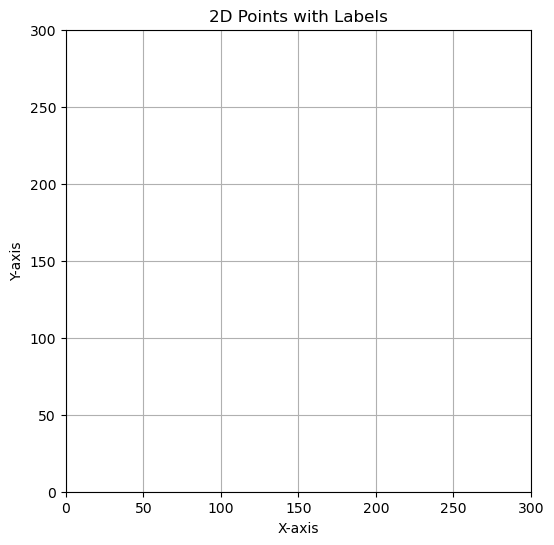

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: an array of points and their corresponding labels
# Replace this with your actual array of 2D points and labels
points = np.array(records)
labels = np.arange(len(points))

# Unpack the points into x and y coordinates
x, y = points[:, 0], points[:, 1]

# Create a figure and axis with a specific size
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust the figure size

# Set the limits of x and y axis based on your points range
ax.set_xlim([0, r_img_width])
ax.set_ylim([0, r_img_height])

# Scatter plot
ax.scatter(x, y)

# Annotate each point with its label
for i, label in enumerate(labels):
    ax.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(5,-5), ha='center')

# Optionally, add grid, labels, title, etc.
ax.grid(True)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Points with Labels')

plt.show()


In [5]:
# crop 裁剪图片

import cv2
import matplotlib.pyplot as plt

def crop_rotate(image, center, size, angle):
    """
    Crop and rotate a region from an image.

    :param image: Source image
    :param center: Tuple (x, y) - the center of the region to crop
    :param size: Tuple (width, height) - the size of the region to crop
    :param angle: Rotation angle in degrees
    :return: Cropped and rotated image region
    """

    # Get rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Perform rotation
    rotated = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    # Calculate the coordinates of the top-left corner of the cropped region
    x = int(center[0] - size[0] / 2)
    y = int(center[1] - size[1] / 2)

    # Crop the region
    # 防止出现超出数组范围的情况

    # Define row and column ranges
    start_row, end_row = y, y + size[0]  # Example row range
    start_col, end_col = x, x + size[1]  # Example column range

    # Define the fill value for out-of-bounds indices
    fill_value = 0.0

    # 对超出区域的处理
    cropped = [[rotated[i][j] if i >= 0 and i < len(rotated) and j >= 0 and j < len(rotated[i]) else fill_value 
          for j in range(start_col, end_col)] 
         for i in range(start_row, end_row)]
    # cropped = rotated[y:y + size[1], x:x + size[0]]

    return cropped

# Specify center, size, and angle
center = (int(best_position[0]), int(best_position[1]))  # Example center position (x, y)
size = (f_img_height, f_img_width)      # Example size (height, width)
angle = 0           # Example rotation angle in degrees

# Crop and rotate
cropped_image = crop_rotate(refered_img, center, size, angle)

# test my fitness ok? okay.
test_p = [220., 155.]
tesnor_p = torch.tensor(test_p)

fitness_val, cropped_image_fit = fintess(test_p)

test_cropped_image = np.array(crop_rotate(refered_img, test_p, size, angle))
print(f"fitness: {fitness_val}")
print(f"mi: {mutual_information(floated_img, test_cropped_image)}")
print(f"center: {center}")

# Display the images
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1), plt.imshow(refered_img, cmap='gray'), plt.title('referred')
plt.subplot(2, 2, 2), plt.imshow(floated_img, cmap='gray'), plt.title('floated')
plt.subplot(2, 2, 3), plt.imshow(cropped_image_fit, cmap='gray'), plt.title('cropped_image_fit')
plt.subplot(2, 2, 4), plt.imshow(best_regi_img, cmap='gray'), plt.title('best_regi_img')

# Question: 
# 1. 使用的坐标系是哪个？需要确定裁剪区域在图像的哪一位置。图像是先进行了旋转，再进行了移动，先不管旋转后的超出区域直接丢弃的处理。
# 2. 裁剪超过对应区域怎么办？用0填充

fitness: 0.06670409082825214
mi: 0.06670409082825264
center: (818, 1850)


(<Axes: title={'center': 'best_regi_img'}>,
 Text(0.5, 1.0, 'best_regi_img'))

: 